In [19]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
from torch.nn import DataParallel

import numpy as np
from torch.utils.tensorboard import SummaryWriter
from scipy.io import loadmat
from os import listdir
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset


In [37]:
        
class LSPet(Dataset):
    
    def __init__(self, path, transforms, image_size, hmap_size = 0, subset_size=1000):
        self.image_size = image_size
        self.hmap_size = hmap_size
        self.path = path
        self.joints = loadmat(self.path + 'joints.mat')['joints'].T
        self.transforms = transforms
        self.subset_size = subset_size  # New parameter to specify the subset size
        self.get_paths()
        
    def get_paths(self):
        self.paths = listdir(self.path + 'images/')
        self.paths.sort()
        
        if self.subset_size is not None:
            # Use only the first `subset_size` images
            self.paths = self.paths[:self.subset_size]
            self.joints = self.joints[:self.subset_size]
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        
        path = self.path + 'images/' + self.paths[index]
        image, x_scale, y_scale = load_image(path, self.transforms, self.image_size)
        
        joints, center = get_joints(self.joints[index], (x_scale, y_scale), self.image_size)

        mask = torch.from_numpy(self.joints[index].T[:,2:]).reshape(-1).float()

        if self.hmap_size == 0:
            return image, joints, center, mask
        
        if self.hmap_size > 0:
            points = joints.reshape(14, 2) * self.hmap_size
            hmap = gen_hmap(self.hmap_size, self.hmap_size, points.numpy(), s=1.5)
            background = torch.sum(hmap, axis=0)
            hmap = torch.cat([hmap, background.unsqueeze(0)], axis=0)
            center = gen_hmap(self.hmap_size, self.hmap_size, [[center[0] * self.hmap_size, center[1] * self.hmap_size]], s=3)
            return image, hmap, center, mask

# load and transform images and return the image and the x, y scaling
def load_image(path, transforms, size):
    image = Image.open(path)
    image_size = image.size
    image = transforms(image)
    x_scale = size[0] / image_size[0]
    y_scale = size[1] / image_size[1]
    return image, x_scale, y_scale

# get joints and center points
def get_joints(joints, scales, size):
    x_joints = (joints.T[:,:1] * scales[0]) / size[0]
    y_joints = (joints.T[:,1:2] * scales[1]) / size[1]
    joints = np.concatenate((x_joints, y_joints), axis=1).reshape(-1)
    joints = torch.from_numpy(joints).float()
    center = [sum(x_joints[x_joints>0])/len(x_joints[x_joints>0]), sum(y_joints[y_joints>0])/len(y_joints[y_joints>0])]
    return joints, center


# generate gaussian distribution heatmap
def gaussian(x0, y0, sigma, width, height):
    x = np.arange(0, width, 1, float)
    y = np.arange(0, height, 1, float)[:, np.newaxis]
    return np.exp(-(((x-x0)**2 + (y - y0)**2 )/ (2 * sigma**2)))

# Generate heatmaps for n points
def gen_hmap(height, width, points, s = 3):
    npoints = len(points)
    hmap = np.zeros((height, width, npoints), dtype = np.float64)
    for i in range(npoints):
        if points[i][1] >= 0 and points[i][0] >= 0:
            if points[i][0] >= height: points[i][0] = height - 1
            if points[i][1] >= width: points[i][1] = width - 1
            hmap[:,:,i] = gaussian(points[i][1],points[i][0],s,height, width)
        else:
            hmap[:,:,i] = np.zeros((height, width))
    return torch.from_numpy(hmap.T).float()

In [38]:
# Load data
batch_size = 10

image_size = (256, 256)
hmap_size = 32

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

lsp = LSPet('/kaggle/input/lsp-data/lsp-master/', transform, image_size, hmap_size)
lsp_loader = DataLoader(lsp, batch_size, shuffle=True, num_workers=1)

In [39]:

class CPM(nn.Module):
    def __init__(self):
        super(CPM, self).__init__()
        self.stage1 = CPMStage1()
        self.stage2_image = CPMStage2Image()
        self.stage2 = CPMStageT()
        self.stage3 = CPMStageT()
        self.stage4 = CPMStageT()


    def forward(self, image, center_map):
        stage1_maps = self.stage1(image)
        stage2image_maps = self.stage2_image(image)
        stage2_maps = self.stage2(stage1_maps, stage2image_maps, center_map)
        stage3_maps = self.stage3(stage2_maps, stage2image_maps, center_map)
        stage4_maps = self.stage4(stage3_maps, stage2image_maps, center_map)

        return stage1_maps, stage2_maps, stage3_maps, stage4_maps


class CPMStage1(nn.Module):
    def __init__(self):
        super(CPMStage1, self).__init__()
        self.k = 14

        self.conv1 = nn.Conv2d(3, 128, kernel_size=9, padding=4)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=9, padding=4)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=9, padding=4)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 32, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(32, 512, kernel_size=9, padding=4)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=1)
        self.conv7 = nn.Conv2d(512, self.k + 1, kernel_size=1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.conv7(x)

        return x


class CPMStage2Image(nn.Module):
    def __init__(self):
        super(CPMStage2Image, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=9, padding=4)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=9, padding=4)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=9, padding=4)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 32, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))

        return x


class CPMStageT(nn.Module):
    def __init__(self):
        super(CPMStageT, self).__init__()
        self.k = 14

        self.conv_image = nn.Conv2d(self.k + 1, self.k + 1, kernel_size=5, padding=2)

        self.conv1 = nn.Conv2d(32 + self.k + 2, 128, kernel_size=11, padding=5)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=11, padding=5)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=11, padding=5)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=1, padding=0)
        self.conv5 = nn.Conv2d(128, self.k + 1, kernel_size=1, padding=0)

    def forward(self, stage1_maps, stage2image_maps, center_map):

        x = F.relu(self.conv_image(stage1_maps))
        x = torch.cat([stage2image_maps, x, center_map], dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)

        return x


In [40]:
# Initialize the model
model = CPM().cuda()
criterion = torch.nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [41]:
# Add network into tensorboard
tb = SummaryWriter()

data = next(iter(lsp_loader))
inputs = data[0].cuda()
center_map = data[2].cuda()
tb.add_graph(model, (inputs, center_map))



In [42]:
model = DataParallel(model).cuda()

for epoch in range(50):
    print(epoch)
    for batch, batch_data in enumerate(lsp_loader):

        model.zero_grad()

        input_image = batch_data[0].cuda()
        joints_hmap = batch_data[1].cuda()
        center_hmap = batch_data[2].cuda()
        # mask = batch_data[3].cuda()

        predictions = model(input_image, center_hmap)

        loss = 0
        for prediction in predictions:
            loss += criterion(prediction, joints_hmap) * 15360
        loss.backward()
        optimizer.step()

        # Tensorboard
        tb.add_scalar('Loss', loss, 1250*epoch + batch)

        if batch % 100 == 0:
            print('Batch: {}, Loss: {}, Epoch: {}'.format(batch, loss, epoch))
            # Add keypoints loss of testing data
    
    # Tensorboard
    for name, weight in model.named_parameters():
        tb.add_histogram(name, weight, epoch)
        tb.add_histogram(f'{name}.grad', weight.grad, epoch)        

    torch.cuda.empty_cache()
    torch.save(model.state_dict(), './cpm{}.weights'.format(epoch))

tb.close()

0
Batch: 0, Loss: 1396.74658203125, Epoch: 0
1
Batch: 0, Loss: 683.2887573242188, Epoch: 1
2
Batch: 0, Loss: 762.2699584960938, Epoch: 2
3
Batch: 0, Loss: 752.3787231445312, Epoch: 3
4
Batch: 0, Loss: 701.5961303710938, Epoch: 4
5
Batch: 0, Loss: 507.7587585449219, Epoch: 5
6
Batch: 0, Loss: 518.055908203125, Epoch: 6
7
Batch: 0, Loss: 491.09503173828125, Epoch: 7
8
Batch: 0, Loss: 524.6678466796875, Epoch: 8
9
Batch: 0, Loss: 570.5363159179688, Epoch: 9
10
Batch: 0, Loss: 469.66741943359375, Epoch: 10
11
Batch: 0, Loss: 578.8582763671875, Epoch: 11
12
Batch: 0, Loss: 517.6698608398438, Epoch: 12
13
Batch: 0, Loss: 507.9768981933594, Epoch: 13
14
Batch: 0, Loss: 489.2231140136719, Epoch: 14
15
Batch: 0, Loss: 443.45672607421875, Epoch: 15
16
Batch: 0, Loss: 456.31524658203125, Epoch: 16
17
Batch: 0, Loss: 424.4146423339844, Epoch: 17
20
Batch: 0, Loss: 432.957275390625, Epoch: 20
21
Batch: 0, Loss: 390.8593444824219, Epoch: 21
22
Batch: 0, Loss: 455.22308349609375, Epoch: 22
23
Batch: 

In [60]:
import matplotlib.pyplot as plt


def show_pose(image, pose, ignore_joints = None):
    t = transforms.ToPILImage()
    # image -> tensor, pose -> tensor[28]
    image_size = image.shape[1]
    plt.figure(figsize=(20, 20))
    ax1 = plt.subplot(121, aspect='equal')
    plt.imshow(t(image))
    pose = pose.reshape(14, 2)
    for i, j in [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7), (7, 8), (9, 10), (10, 11), (8, 12), (9, 12), (12, 13), (3, 12), (2, 12)]:
        if ignore_joints == None:
            plt.plot([pose[i][0] * image_size, pose[j][0]* image_size], [pose[i][1] * image_size, pose[j][1] * image_size ], '-o',lw=2)
        else: 
            if ignore_joints[i] and ignore_joints[j]:
                plt.plot([pose[i][0] * image_size, pose[j][0]* image_size], [pose[i][1] * image_size, pose[j][1] * image_size ], '-o',lw=2)
    
    plt.subplot(122, aspect='equal', sharex=ax1, sharey=ax1)

    for i, j in [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7), (7, 8), (9, 10), (10, 11), (8, 12), (9, 12), (12, 13), (3, 12), (2, 12)]:
        if ignore_joints == None:
            plt.plot([pose[i][0] * image_size, pose[j][0]* image_size], [pose[i][1] * image_size, pose[j][1] * image_size ], '-o',lw=2)
        else: 
            if ignore_joints[i] and ignore_joints[j]:
                plt.plot([pose[i][0] * image_size, pose[j][0]* image_size], [pose[i][1] * image_size, pose[j][1] * image_size ], '-o',lw=2)

def show_pose_from_hmap(image, hmap, mask = None):
    pose = points_from_hmap(hmap)
    show_pose(image, pose, mask)

def points_from_hmap(hmaps):
    points = []
    for hmap in hmaps:
        x, y = np.unravel_index(np.argmax(hmap), hmap.shape)
        points.append(y/hmap.shape[1])
        points.append(x/hmap.shape[0])
    return np.array(points)


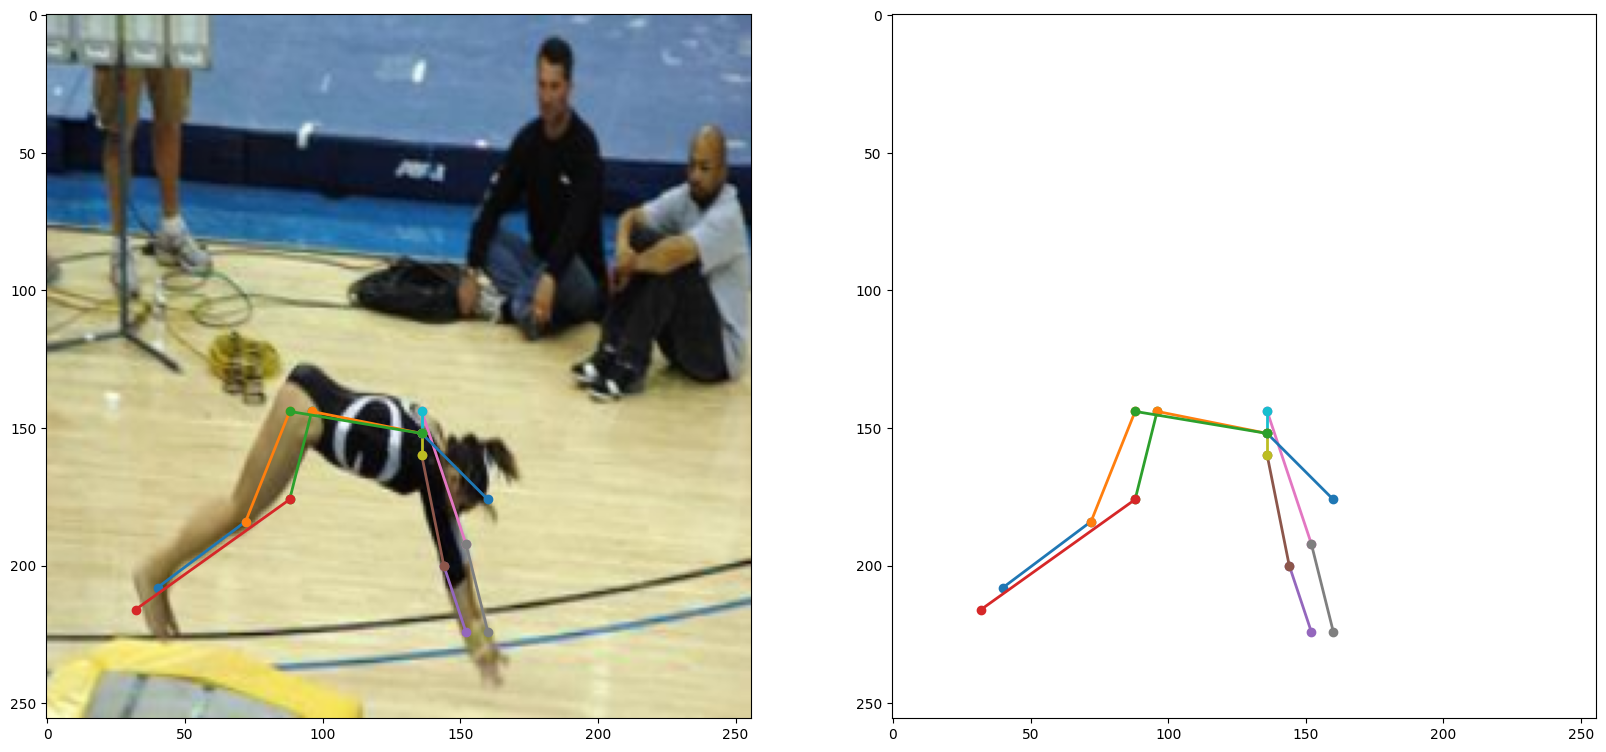

In [61]:
rn = 35
test_image, hmap, center_hmap, _ = lsp.__getitem__(rn)
test_predictions =  model(test_image.unsqueeze(0).cuda(), center_hmap.unsqueeze(0).cuda())
show_pose_from_hmap(test_image, test_predictions[3].squeeze()[:14,:,:].cpu().detach())
# show_hmap(test_image, hmap)
# test_predictions[0].shape

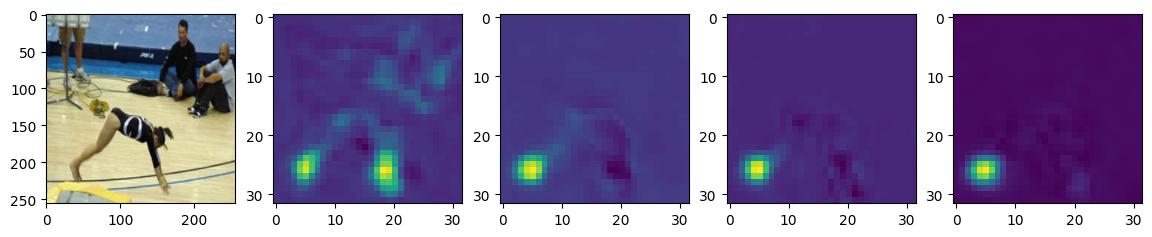

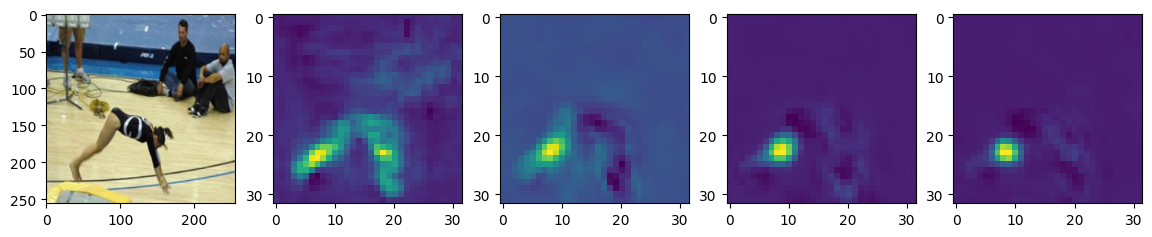

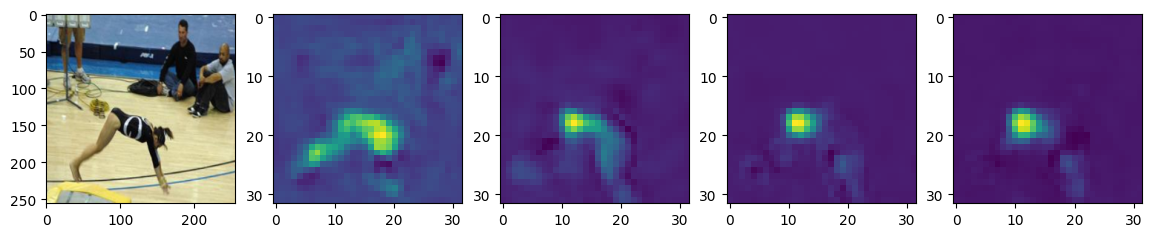

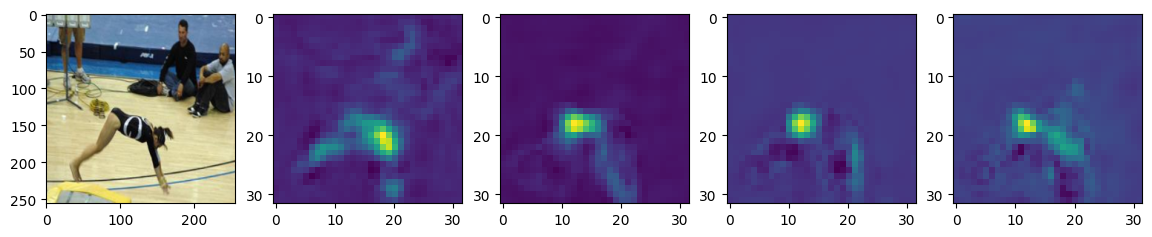

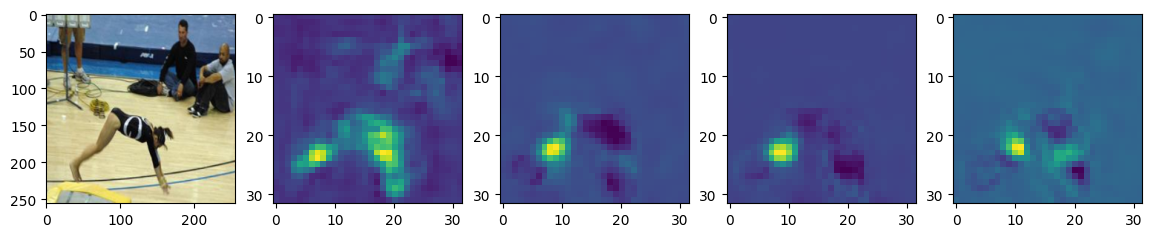

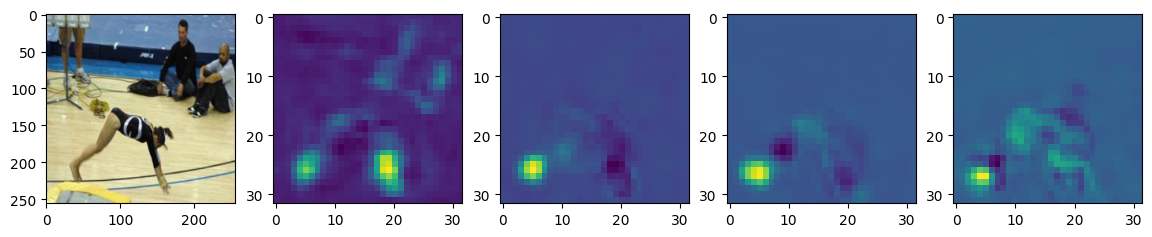

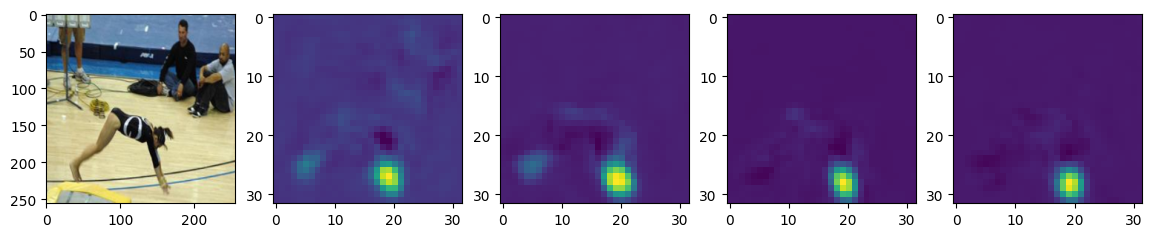

In [64]:
import matplotlib.pyplot as plt
def show_hmap_cpm(image, hmap, joint):
    t = transforms.ToPILImage()

    plt.figure(figsize=(20, 30))
    plt.subplot(1, 7, 1)
    plt.imshow(t(image))
    for i, prediction in enumerate(hmap):
        plt.subplot(1, 7, i + 2)
        plt.imshow(prediction.squeeze()[joint].squeeze().cpu().detach())

for i in range(7):
    show_hmap_cpm(test_image, test_predictions, i)
    plt.savefig('test{}_hmap.png'.format(i+1), dpi=72, bbox_inches='tight')

